# Visualisations

This notebooks showcases the data and model in several ways.
- The data tranformation is showed by comparing $X_t$ with $U_{t+1}$.
- The predictions of the baseline GMM is shown.
- The predictions of the non-recurrent MDN is shown.
- The predictions of the RMDN is shown.

### Imports

In [1]:
# Imports

# Misc
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
import pickle

# Visualiation tools
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import animation, rc
from IPython.display import HTML, Image
from matplotlib import rc
# Plot settings
plt.style.use('seaborn-dark')
plt.rcParams.update({'font.size': 20})
plt.rcParams['figure.dpi'] = 100
# Latex font in plots
rc('text', usetex=True)
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})

# Pyro/PyTorch
import torch
from torch import nn
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, TraceEnum_ELBO, Predictive, NUTS, MCMC, config_enumerate
from pyro.infer.autoguide import AutoDelta, AutoDiagonalNormal, AutoMultivariateNormal
from pyro.optim import Adam, ClippedAdam
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from pyro.distributions import MultivariateNormal as MN
from pyro.ops.indexing import Vindex

# Implemented modules
from util import *
from model import RMDN, NonRMDN

### Load data

In [2]:
# Load data files

X_train_tensor, X_val_tensor, X_test_tensor =   torch.load("./data/X_train_tensor.pt"), \
                                                torch.load("./data/X_val_tensor.pt"),   \
                                                torch.load("./data/X_test_tensor.pt")
U_train_tensor, U_val_tensor, U_test_tensor =   torch.load("./data/U_train_tensor.pt"), \
                                                torch.load("./data/U_val_tensor.pt"),   \
                                                torch.load("./data/U_test_tensor.pt")
N_t_train, N_t_valid, N_t_test = np.load("./data/N_t_train.npy"), \
                                 np.load("./data/N_t_val.npy"),   \
                                 np.load("./data/N_t_test.npy")

# Concatenation
X_train_val = torch.cat((X_train_tensor, X_val_tensor), 1)
U_train_val = torch.cat((U_train_tensor, U_val_tensor), 1)
N_train_val = np.hstack((N_t_train, N_t_valid))

## Data overview

Here, the data is visualised. The observations at time $t$, i.e. $X_t$, are gridded into a square 32 by 32 grid. This grid is denoted as $U_{t+1}$ and thus acts acts as the input for the model at timr $t+1$.

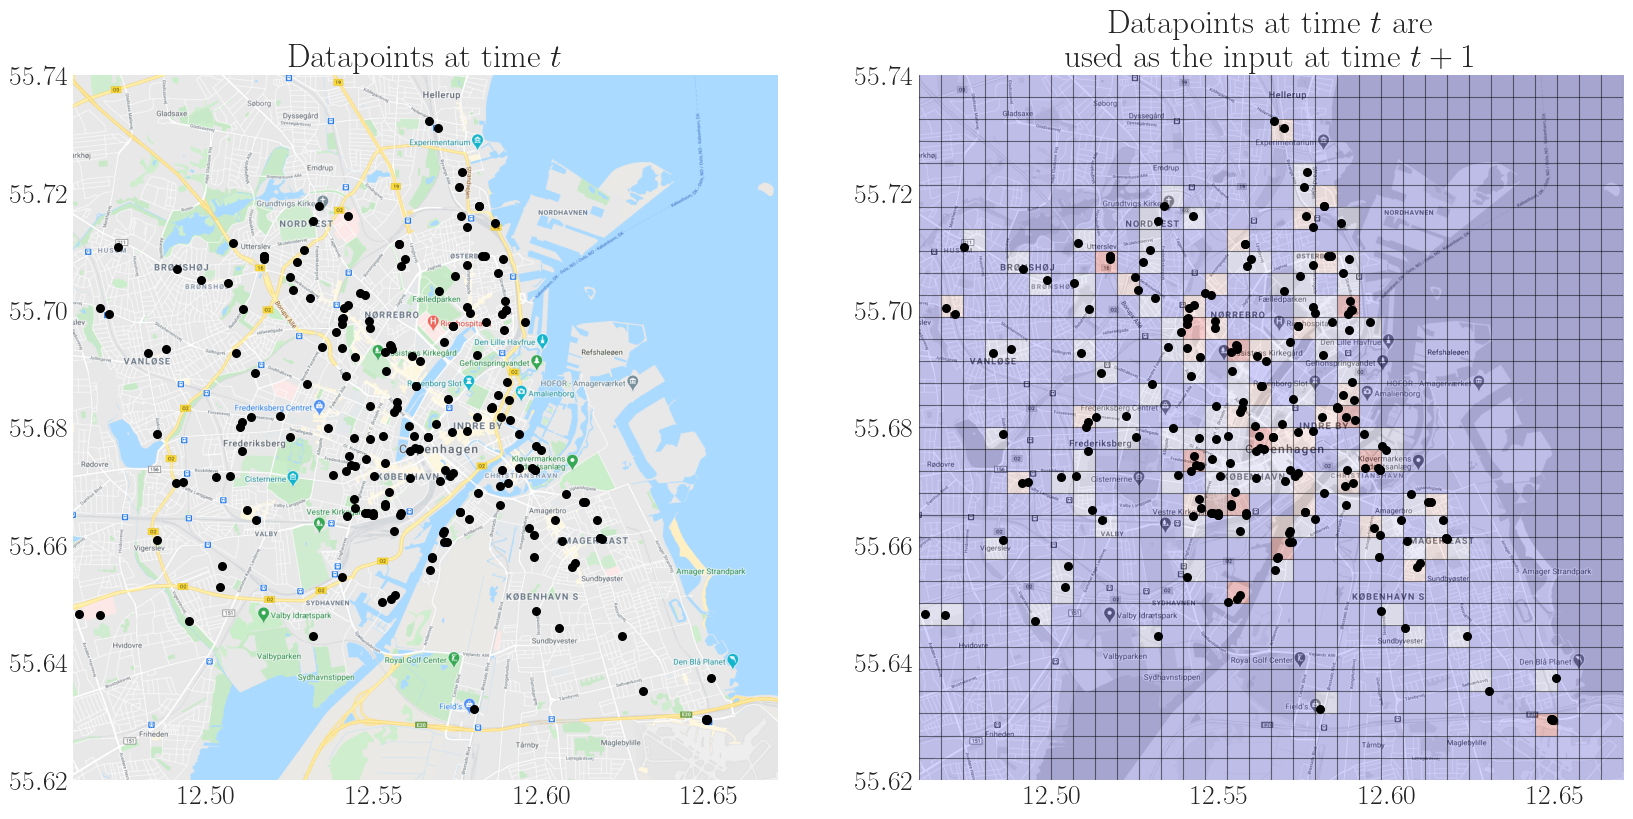

In [3]:
# Show example of data     

# Data to be showcased
t = 104
U = U_train_tensor
X = X_train_tensor
mask = N_t_train

# Unpack Tensors 
lon = X[:, t, :mask[t], 0].squeeze().numpy()*lonstd+lonmean
lat = X[:, t, :mask[t], 1].squeeze().numpy()*latstd+latmean

# Prepare CPH image and U-image 
cph_img1 = np.asarray(Image.open('images/cph_2.png'))
cph_img2 = np.asarray(Image.open('images/cph_2.png').convert("L"))
image = U[:, t+1, :, :].squeeze().numpy()

# Plot preparations
fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[1].set_xticks(np.linspace(lonMin, lonMax, 32+1), minor=True)
ax[1].set_yticks(np.hstack((np.linspace(latMin, latMax, 32+1), 55.68001)), minor=True) # 55.68001 is added due to a bug where the line was missing
ax[1].xaxis.grid(True, which='minor', color='k', alpha=0.5)
ax[1].yaxis.grid(True, which='minor', color='k', alpha=0.5)
ax[0].xaxis.set_tick_params(labelsize=20)
ax[0].yaxis.set_tick_params(labelsize=20)
ax[1].xaxis.set_tick_params(labelsize=20)
ax[1].yaxis.set_tick_params(labelsize=20)
ax[0].title.set_text(f'Datapoints at time $t$')
ax[1].title.set_text(f'Datapoints at time $t$ are\nused as the input at time $t+1$')
#plt.suptitle('Overview of data')

# Plot raw datapoints on map
ax[0].imshow(cph_img1, extent=extent, aspect=aspect)
ax[0].scatter(x=lon,y=lat, color='k', s=30)

# Show gridlines and heatmap of datapoints
ax[1].imshow(cph_img2, extent=extent, aspect=aspect, cmap='gray')
ax[1].imshow(image, aspect=aspect, extent=extent, cmap='seismic'
          ,vmin=-0.01, vmax=np.max(image), alpha=0.2, origin='lower')
ax[1].scatter(x=lon,y=lat, color='k', s=30)


#plt.savefig('data_overview.png', bbox_inches='tight')

plt.show()
    

## Baseline model

A baseline Gaussian Mixture Model (GMM) is trained on the training dataset. The log-likelihoods of the training, validation, and testing set are then computed and shown.

Finally, the predictions are shown alongside the true values. The predictions here are simply the final variables of the mixture densities.

In [14]:
# Concatenate all time intervals into single tensors
X_train_full = np.zeros((np.sum(N_t_train), 2))
prev_count = 0
for i, count in enumerate(N_t_train):
    X_train_full[prev_count:(prev_count+count), :] = X_train_tensor[:, i, :count, :].numpy()[0]
    prev_count+=count
X_val_full = np.zeros((np.sum(N_t_valid), 2))
prev_count = 0
for i, count in enumerate(N_t_valid):
    X_val_full[prev_count:(prev_count+count), :] = X_val_tensor[:, i, :count, :].numpy()[0]
    prev_count+=count
X_test_full = np.zeros((np.sum(N_t_test), 2))
prev_count = 0
for i, count in enumerate(N_t_test):
    X_test_full[prev_count:(prev_count+count), :] = X_test_tensor[:, i, :count, :].numpy()[0]
    prev_count+=count 

# Transform to same format as input for RMDN for fair comparison    
latmax = (latMax-latmean)/latstd
latmin = (latMin-latmean)/latstd
lonmax = (lonMax-lonmean)/lonstd
lonmin = (lonMin-lonmean)/lonstd
bins_lat = np.linspace(latmin, latmax, 33)
bins_lon = np.linspace(lonmin, lonmax, 33)
binidx_lat = np.digitize(X_train_full[:,1], bins=bins_lat)
binidx_lon = np.digitize(X_train_full[:,0], bins=bins_lon)
X_train_base = np.vstack((bins_lon[binidx_lon], bins_lat[binidx_lat]))    
    
# Initialise and fit model
baseline = GaussianMixture(n_components=30).fit(X_train_base.T)

# Compute loglikelihood
baseline_ll_train = baseline.score(X_train_full) * np.sum(N_t_train)
baseline_ll_validation = baseline.score(X_val_full) * np.sum(N_t_valid)
baseline_ll_test = baseline.score(X_test_full) * np.sum(N_t_test)
print(f'Baseline training LL:\t{baseline_ll_train:.4f}')
print(f'Baseline validation LL:\t{baseline_ll_validation:.4f}')
print(f'Baseline testing LL:\t{baseline_ll_test:.4f}')

Baseline training LL:	-27111.6941
Baseline validation LL:	-15399.2475
Baseline testing LL:	-12863.7975


In [15]:
# Compute LL on baseline

# Define grid
n = 100
grid = np.zeros((n, n))
latvals = np.linspace(latmin, latmax, n)
lonvals = np.linspace(lonmin, lonmax, n)
xx, yy = np.meshgrid(lonvals, latvals)

# Form 2d array
baseline_input = np.vstack((xx.flatten(), yy.flatten())).T
baseline_ll = baseline.score_samples(baseline_input)
baseline_ll = baseline_ll.reshape((n,n))

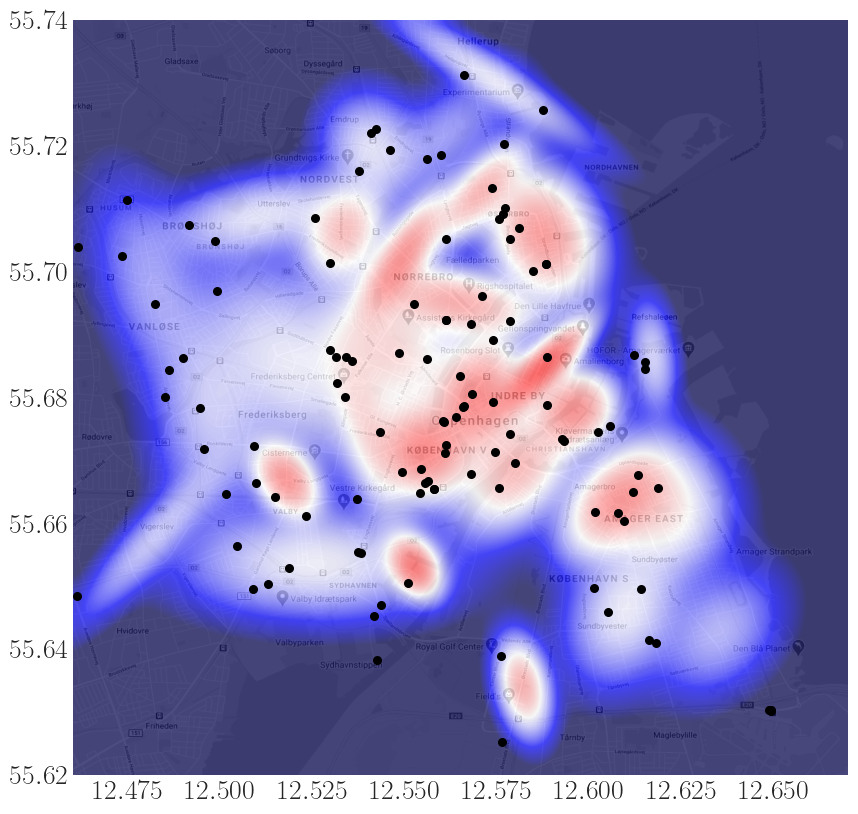

In [16]:
visualise_baseline_mix(baseline_ll, X_test_tensor, mask=N_t_test, t = 40, figsize=(10,10))#, filename='images/gmm_t40.png')

## Non-recurrent MDN

In [17]:
# Instantiate and load model
grid = U_train_tensor.size(3)
MDN = NonRMDN(input_dim=grid, hidden_dim=128, LSTM_input=32, output_dim=2, LSTM_dim=32, K = 60)
MDN.load_state_dict(torch.load('models/MDN_trained_60'))
MDN.eval()

NonRMDN(
  (FeatureExtractor): FeatureExtractor(
    (input_to_hidden): Linear(in_features=1024, out_features=128, bias=True)
    (hidden_to_hidden): Linear(in_features=128, out_features=128, bias=True)
    (hidden_to_output): Linear(in_features=128, out_features=32, bias=True)
    (elu): ELU(alpha=1.0)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (MDN): MDN(
    (input_to_hidden): Linear(in_features=32, out_features=128, bias=True)
    (hidden_to_hidden): Linear(in_features=128, out_features=128, bias=True)
    (hidden_to_loc): Linear(in_features=128, out_features=120, bias=True)
    (hidden_to_sigma): Linear(in_features=128, out_features=120, bias=True)
    (hidden_to_off_diag): Linear(in_features=128, out_features=60, bias=True)
    (hidden_to_mix): Linear(in_features=128, out_features=60, bias=True)
    (elu): ELU(alpha=1.0)
    (softmax): Softmax(dim=2)
    (softplus): Softplus(beta=1, threshold=20)
    (dropout1): Dropout(p=0.3, inplace=False)
    (dropout2): Dropout(p=0.5,

In [18]:
# Define grid
n = 100
grid = np.zeros((n, n))
latvals = torch.linspace(latmin, latmax, n)
lonvals = torch.linspace(lonmin, lonmax, n)
xx, yy = torch.meshgrid(lonvals, latvals)

# Define sequence lengths
num_seq_train = U_train_tensor.size(1)
num_seq_val   = U_val_tensor.size(1)
num_seq_test  = U_test_tensor.size(1)

# Training
grid_tensor = torch.zeros((1, num_seq_train, n*n, 2))
grid_tensor[0, :, :, :] = torch.cat((xx.reshape(-1,1), yy.reshape(-1,1)),1)
grid_mask = (np.ones(num_seq_train)*n*n).astype(int)
# Compute likelihood for each data point
LL_MDN_train = MDN.get_loglikelihood(X=grid_tensor, U=U_train_tensor, mask=grid_mask)
LL_MDN_train = LL_MDN_train.reshape(-1, num_seq_train, n, n)

# Validation
grid_tensor = torch.zeros((1, num_seq_val, n*n, 2))
grid_tensor[0, :, :, :] = torch.cat((xx.reshape(-1,1), yy.reshape(-1,1)),1)
grid_mask = (np.ones(num_seq_val)*n*n).astype(int)
# Compute likelihood for each data point
LL_MDN_val = MDN.get_loglikelihood(X=grid_tensor, U=U_val_tensor, mask=grid_mask)
LL_MDN_val = LL_MDN_val.reshape(-1, num_seq_val, n, n)

# Validation
grid_tensor = torch.zeros((1, num_seq_test, n*n, 2))
grid_tensor[0, :, :, :] = torch.cat((xx.reshape(-1,1), yy.reshape(-1,1)),1)
grid_mask = (np.ones(num_seq_test)*n*n).astype(int)
# Compute likelihood for each data point
LL_MDN_test = MDN.get_loglikelihood(X=grid_tensor, U=U_test_tensor, mask=grid_mask)
LL_MDN_test = LL_MDN_test.reshape(-1, num_seq_test, n, n)

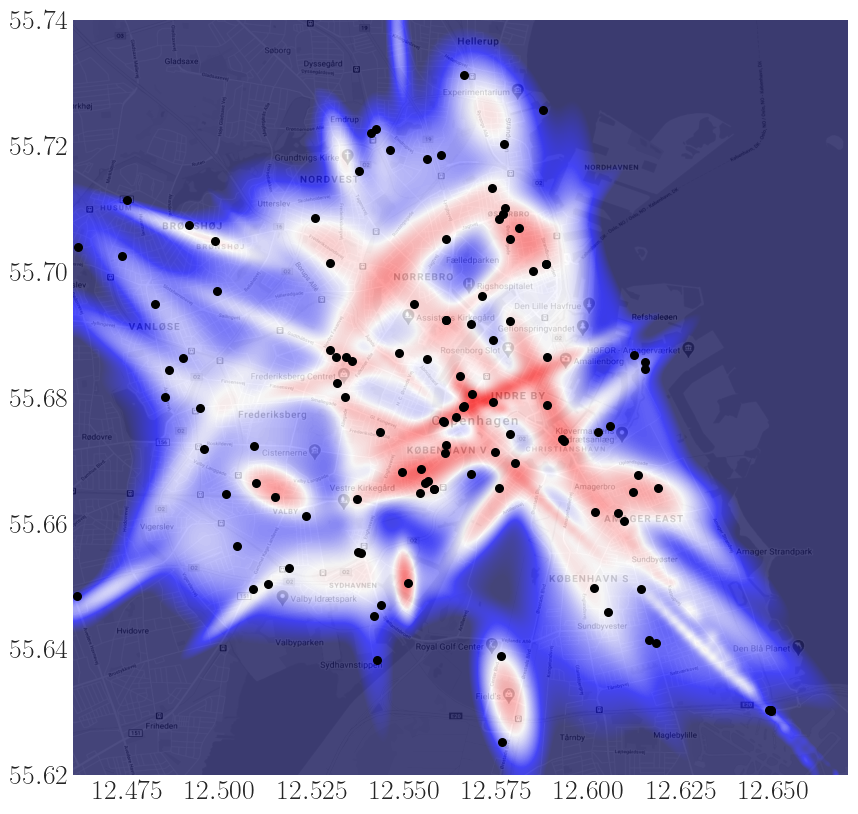

In [19]:
visualise_predictions(LL_MDN_test, X=X_test_tensor, mask=N_t_test, t=40, filename='images/mdn_t40_60.png')

## RMDN

In [21]:
# Instantiate and load model
grid = U_train_tensor.size(3)
RMDN = RMDN(input_dim=grid, hidden_dim=128, LSTM_input=32, output_dim=2, LSTM_dim=32, K=60, use_cuda=False)
RMDN.load_state_dict(torch.load('models/RMDN_trained_60'))
# Set to evaluation
RMDN.eval()

RMDN(
  (FeatureExtractor): FeatureExtractor(
    (input_to_hidden): Linear(in_features=1024, out_features=128, bias=True)
    (hidden_to_hidden): Linear(in_features=128, out_features=128, bias=True)
    (hidden_to_output): Linear(in_features=128, out_features=32, bias=True)
    (elu): ELU(alpha=1.0)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (MDN): MDN(
    (input_to_hidden): Linear(in_features=32, out_features=128, bias=True)
    (hidden_to_hidden): Linear(in_features=128, out_features=128, bias=True)
    (hidden_to_loc): Linear(in_features=128, out_features=120, bias=True)
    (hidden_to_sigma): Linear(in_features=128, out_features=120, bias=True)
    (hidden_to_off_diag): Linear(in_features=128, out_features=60, bias=True)
    (hidden_to_mix): Linear(in_features=128, out_features=60, bias=True)
    (elu): ELU(alpha=1.0)
    (softmax): Softmax(dim=2)
    (softplus): Softplus(beta=1, threshold=20)
    (dropout1): Dropout(p=0.3, inplace=False)
    (dropout2): Dropout(p=0.5, in

In [22]:
# Define grid
n = 100
grid = np.zeros((n, n))
latvals = torch.linspace(latmin, latmax, n)
lonvals = torch.linspace(lonmin, lonmax, n)
xx, yy = torch.meshgrid(lonvals, latvals)

# Define sequence lengths
num_seq_train = U_train_tensor.size(1)
num_seq_val   = U_val_tensor.size(1)
num_seq_test  = U_test_tensor.size(1)

# Train visualisation
grid_tensor = torch.zeros((1, num_seq_train, n*n, 2))
grid_tensor[0, :, :, :] = torch.cat((xx.reshape(-1,1), yy.reshape(-1,1)),1)
grid_mask = (np.ones(num_seq_train)*n*n).astype(int)
# Compute likelihood for each data point
LL_RMDN_train = RMDN.get_loglikelihood(X=grid_tensor, U=U_train_tensor, mask=grid_mask, 
                                       X_init=None, U_init=None, mask_init=None)
LL_RMDN_train = LL_RMDN_train.reshape(-1, num_seq_train, n, n)

# Validation visualisation
grid_tensor = torch.zeros((1, num_seq_val, n*n, 2))
grid_tensor[0, :, :, :] = torch.cat((xx.reshape(-1,1), yy.reshape(-1,1)),1)
grid_mask = (np.ones(num_seq_val)*n*n).astype(int)
# Expand tensors
X_init = torch.zeros(1, X_train_tensor.size(1), n*n, 2)
X_init[:, :, :X_train_tensor.size(2), :] = X_train_tensor[:, :, :, :]
# Compute likelihood for each data point
LL_RMDN_val = RMDN.get_loglikelihood(X=grid_tensor, U=U_val_tensor, mask=grid_mask, 
                                     X_init=X_init, U_init=U_train_tensor, mask_init=N_t_train)
LL_RMDN_val = LL_RMDN_val.reshape(-1, num_seq_val, n, n)

# Test visualisation
grid_tensor = torch.zeros((1, num_seq_test, n*n, 2))
grid_tensor[0, :, :, :] = torch.cat((xx.reshape(-1,1), yy.reshape(-1,1)),1)
grid_mask = (np.ones(num_seq_test)*n*n).astype(int)
# Create and fill tensor to pre-run RMDN
X_init = torch.zeros(1, X_train_tensor.size(1)+X_val_tensor.size(1), n*n, 2)
X_init[:,:,:X_train_val.size(2), :] = X_train_val
# Stack train and validation masks and input
mask_init = np.hstack((N_t_train, N_t_valid))
U_init = torch.cat((U_train_tensor, U_val_tensor), 1)
# Compute likelihood for each data point
LL_RMDN_test = RMDN.get_loglikelihood(X=grid_tensor, U=U_test_tensor, mask=grid_mask, 
                                      X_init=X_init, U_init=U_init, mask_init=mask_init)
LL_RMDN_test = LL_RMDN_test.reshape(-1, num_seq_test, n, n)


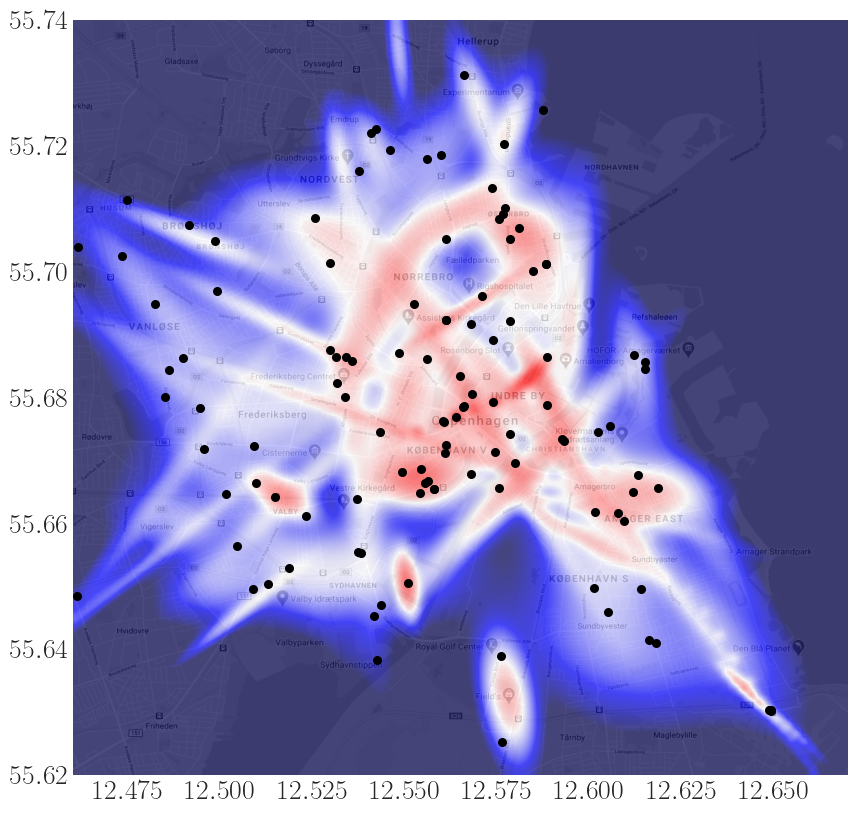

In [44]:
visualise_predictions(LL_RMDN_test, X=X_test_tensor, mask=N_t_test, t=40) #, filename='images/rmdnn_t40_60.png')

## Visualise learning curves

The data is loaded.

In [112]:
with open("models/rmdn_losses_60.txt", "rb") as fp:   
    train_losses = pickle.load(fp)      
with open("models/rmdn_validation_60.txt", "rb") as fp:
    validation_ll = pickle.load(fp)
with open("models/rmdn_train_60.txt", "rb") as fp:
    train_ll = pickle.load(fp)    

Lists are turned into arrays.

In [113]:
train_losses = np.array(train_losses)
validation_ll = np.array(validation_ll)
train_ll = np.array(train_ll)

The training losses, validation LL and training LL are appended to the loaded values as these were not saved while training. They are instead extracted from the prints in the `main`-notebook.

In [114]:
train_losses = np.hstack((train_losses, np.array([2.135, 2.122, 2.130, 2.094, 2.083])))
validation_ll= np.hstack((validation_ll, np.array([-13088.349609375, -13043.0068359375, -13112.0146484375, -13160.8017578125, -13187.884765625])))
train_ll = np.hstack((train_ll, np.array([-20915.01953125, -20556.646484375, -20360.349609375, -20118.6640625,-19981.654296875,])))

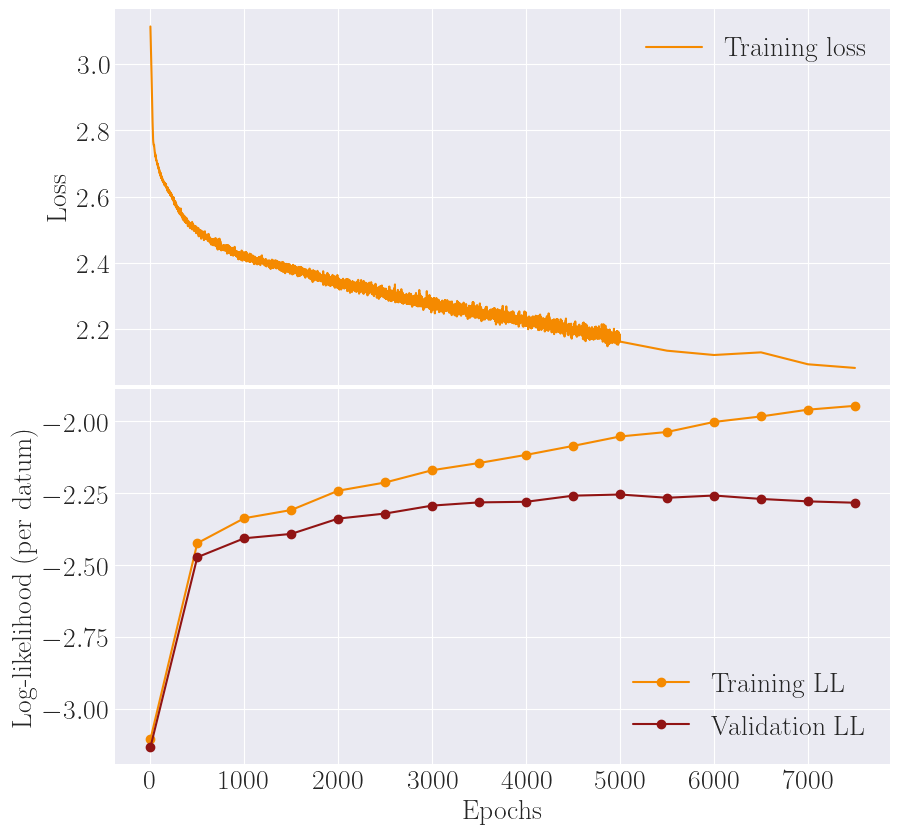

In [115]:
epochs = np.arange(len(train_losses)-5)+1
epochs = np.hstack((epochs, np.array([5500, 6000, 6500, 7000, 7500])))
val_epochs = np.arange(0,7501, 500)
val_epochs[0] = 1

N_train = N_t_train.sum()
N_val   = N_t_valid.sum()

# Plot preparations
fig, ax = plt.subplots(2,1, figsize=(10,10), sharex=True)
plt.subplots_adjust(wspace=0, hspace=0.01)
ax[0].xaxis.set_tick_params(labelsize=20)
ax[0].yaxis.set_tick_params(labelsize=20)
ax[1].xaxis.set_tick_params(labelsize=20)
ax[1].yaxis.set_tick_params(labelsize=20)

ax[0].plot(epochs, train_losses, color="#f58a00", label='Training loss')
ax[0].grid()
ax[0].legend()
ax[0].set_ylabel('Loss')
ax[1].plot(val_epochs, train_ll/N_train,marker='o', color="#f58a00",label='Training LL')
ax[1].plot(val_epochs, validation_ll/N_val, marker='o', color="#911414", label='Validation LL')
ax[1].grid()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Log-likelihood (per datum)')
ax[1].legend()


plt.savefig('images/combined_ll_loss.png', bbox_inches='tight')